# Key: Cathode = 0, Gate = 1, Tritium = 2

# Imports

Install tensorflow in your conda environment. Note that you need to have numpy-1.23.1. When I did this, I had to manually uninstall numpy-1.24.3 then install numpy-1.23.1, before installing tensorflow. The tensorflow install failed to install numpy-1.23.1, itself, even though it told me it was successful.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn

C:\Users\44738\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sn

In [3]:
import pandas as pd
import awkward as ak
import pyarrow.parquet as pq

import hist
from hist import Hist, axis

import matplotlib as mpl
import matplotlib.patches as patches

In [4]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'weight' : 'normal','size'   : 22}
plt.rc('font', **font)
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast

# Load data from Parquet file and convert to strings
data_path = 'padded_waveforms.parquet'
df = pd.read_parquet(data_path)
print(df.head())
arr = ak.from_parquet(data_path) #Awkward DataFrame also created for future use
print(arr.fields) #analogous to df.columns.tolist()

   runID  eventID                                              times  \
0   6940     3177  [-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...   
1   6940     7831  [-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...   
2   6940     9904  [-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...   
3   6940    15136  [-823.0, -813.0, -803.0, -793.0, -783.0, -773....   
4   6940    16478  [-813.0, -803.0, -793.0, -783.0, -773.0, -763....   

                                             samples  length          area  \
0  [0.00036996949347667396, -0.000351915950886905...    1101   9605.476562   
1  [0.0009631378925405443, 0.0009631378925405443,...     932   8454.574219   
2  [-0.003676149994134903, -0.004674938507378101,...     525  10806.775391   
3  [-0.004523166920989752, 0.0026921471580863, -0...     640  11460.135742   
4  [-0.009625015780329704, -0.004182628821581602,...     656  11764.575195   

   max_pulse_height    ext_elec          x          y          r  S2_width  \
0          2.721810 

# Normalising the Data


In this instance, we use awkward arrays. Awkward arrays work very similarly to numpy arrays but they can have different lengths – for example, the times and samples arrays are a different length for every event.

In [5]:
def normalise_array(arr):
    min_val = ak.min(arr, axis=-1)
    max_val = ak.max(arr, axis=-1)
    return (arr - min_val) / (max_val - min_val)

# Apply normalization to each column
normalised_times = normalise_array(arr['times'])
normalised_samples = normalise_array(arr['samples'])
normalised_areas = normalise_array(arr['area'])

# Print or inspect the results
print(normalised_times)
print(normalised_samples)



[[0, 0.000909, 0.00182, 0.00273, 0.00364, ..., 0.997, 0.998, 0.999, 1], ...]
[[0.00238, 0.00212, 0.00198, 0.00223, ..., 0.00251, 0.00211, 0.00133, 0], ...]


# Padding the Data

In [6]:
# Lets pad the time data first using Awkward jargon

# first, an initial check to see if data row entry (training example) has an associated label. filtering for both NaNs and None values.
missing_label_count = len(arr[(arr['label'] != 0) & (arr['label'] != 1) & (arr['label'] != 2)])
print("Number of rows with unexpected or missing labels:", missing_label_count)

nan_areas = len(arr[ak.is_none(arr['area'])])
print("Number of NaN values in area column:", nan_areas)
# print(type(electron_size))



print(len(arr['times']))
print(f"Length Before Padding: {len(arr['times'][0])}")
print("Structure of 'times':", ak.type(arr['times']))


times_lengths = ak.num(normalised_times, axis=1)
max_time_length = ak.max(times_lengths)
max_time_length_index = ak.argmax(times_lengths)

print(f'Results are: \n Max. Length = {max_time_length} \n Max. Length Index = {max_time_length_index}')

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), 'constant') for sub_array in ak.to_list(array)]
        )
    )

# Apply padding
padded_times = np.array(pad_to_max_length(normalised_times, max_time_length))

print(f"Length After Padding: {len(padded_times[0])}")
    

Number of rows with unexpected or missing labels: 0
Number of NaN values in area column: 0
7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828


Now lets pad the Sample data

In [7]:
print(len(arr['samples']))
print(f"Length Before Padding: {len(normalised_samples[0])}")
print("Structure of 'times':", ak.type(arr['samples']))


samples_lengths = ak.num(normalised_samples, axis=1)
max_samples_length = ak.max(samples_lengths)
max_samples_length_index = ak.argmax(samples_lengths)

print(f'Results are: \n Max. Length = {max_samples_length} \n Max. Length Index = {max_samples_length_index}')

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), 'constant') for sub_array in ak.to_list(array)]
        )
    )

# Apply padding
padded_samples = np.array(pad_to_max_length(normalised_samples, max_samples_length))

print(f"Length After Padding: {len(padded_samples[0])}")

7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828


# Creating the Training and Test Data (AwkwardArrays)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Separate times and samples as individual arrays

X = arr[['times', 'samples']] #creates a mini array from mother array with only 'times' and 'samples' columns
#print(X)
y = np.array(arr['label']) # labelled as 0,1 and 2 corresponding to cathode, gate and tritium respectively. this is the true output data#

X_combined = np.concatenate([padded_times, padded_samples], axis=1)
print(X_combined)


# Split the data (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# Verify the shapes of the resulting sets
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

[[0.         0.00090909 0.00181818 ... 0.         0.         0.        ]
 [0.         0.00107411 0.00214823 ... 0.         0.         0.        ]
 [0.         0.0019084  0.00381679 ... 0.         0.         0.        ]
 ...
 [0.         0.00119474 0.00238949 ... 0.         0.         0.        ]
 [0.         0.00136799 0.00273598 ... 0.         0.         0.        ]
 [0.         0.00108225 0.0021645  ... 0.         0.         0.        ]]
Training data shape: (5836, 3656)
Test data shape: (1946, 3656)


# Plotting the S2 Area Spectrum

305.75293803418805
305.75293803418805
 Total Number of Training Examples 7782
1711
1189
4882
7782


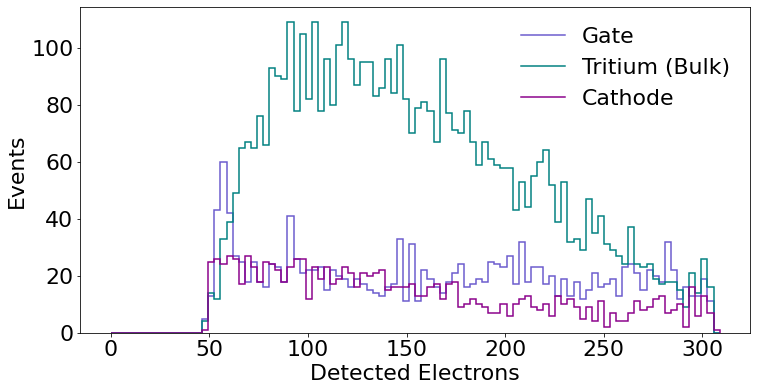

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0)

areas = arr['area']
max_area = max(areas)

bins=100
electron_size = 58.5
print(max(areas)/electron_size)

# create a histogram of area distributions for gate, tritium and cathode data.
# first, boolean masks to filter gate, tritium and cathode data from main Awkward Array.
gate_events = arr[(arr['label'] == 1)].area / electron_size
tritium_events = arr[(arr['label'] == 2)].area / electron_size
cathode_events = arr[(arr['label'] == 0)].area / electron_size

print(max(cathode_events))

print(f' Total Number of Training Examples {len(arr["label"])}')
a = len(gate_events)
b = len(cathode_events)
c = len(tritium_events)

print(a)
print(b)
print(c)
print(a+b+c)


gate_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01),label='S2 Gate Area Distribution')
gate_hist.fill(gate_events)
gate_hist.plot(color='slateblue',density=False,yerr=False,label='Gate')

tritium_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01),label='S2 Gate Tritium Distribution')
tritium_hist.fill(tritium_events)
tritium_hist.plot(color='teal',density=False,yerr=False,label='Tritium (Bulk)')

cathode_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size *1.01),label='S2 Gate Cathode Distribution')
cathode_hist.fill(cathode_events)
cathode_hist.plot(color='darkmagenta',density=False,yerr=False,label='Cathode')

ax.set(xlabel='Detected Electrons',ylabel='Events')
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False,fontsize=22) 
plt.savefig('Figures/Pulse_Spectrum.png', dpi=1800)
plt.show()

1189.0


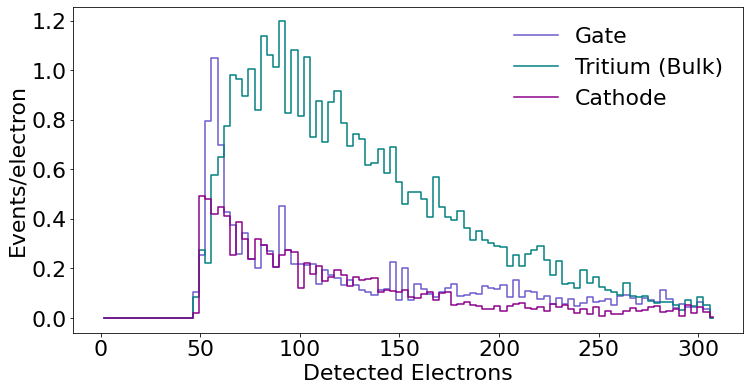

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0)

bin_edges = gate_hist.axes[0].edges  # Get bin edges from one of the histograms
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

# Retrieve and adjust counts for each histogram
gate_counts = gate_hist.view() / bin_centers
tritium_counts = tritium_hist.view() / bin_centers
cathode_counts = cathode_hist.view() / bin_centers

print(cathode_hist.view().sum())


ax.step(bin_centers, gate_counts, where='mid', color='slateblue', label='Gate')
ax.step(bin_centers, tritium_counts, where='mid', color='teal', label='Tritium (Bulk)')
ax.step(bin_centers, cathode_counts, where='mid', color='darkmagenta', label='Cathode')

ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False,fontsize=22) 
plt.savefig('Figures/eventsperelectron.png', dpi=1800)
plt.show()

# Weighting the S2 Area Spectrum

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04178364 0.29438475 0.55512552
 1.01522956 0.89674123 0.42649888 0.34641554 0.30223501 0.30315365
 0.23791094 0.24128005 0.24439488 0.31793553 0.18179549 0.41712822
 0.30789749 0.17476174 0.25905858 0.1933273  0.19710979 0.15507027
 0.15969364 0.19861158 0.16821985 0.13936696 0.1599127  0.12484751
 0.12952929 0.08933054 0.10915389 0.09963791 0.09053122 0.1772506
 0.15356565 0.11121202 0.15389618 0.08802961 0.12336123 0.12105541
 0.10100908 0.07585048 0.13755323 0.08447562 0.12177967 0.09796333
 0.09099165 0.10004295 0.09326109 0.13258904 0.11045133 0.13348438
 0.10712949 0.100745   0.1323657  0.08852721 0.11942417 0.07699293
 0.0982636  0.07489789 0.05650607 0.06433574 0.06349475 0.07103219
 0.0453765  0.08146496 0.06838503 0.07151924 0.06672721 0.06592808
 0.06131564 0.08332293 0.08984691 0.06291423 0.05854431 0.07598087
 0.0751413  

<ipython-input-11-98ebca07c6fa>:46: RuntimeWarning: divide by zero encountered in double_scalars
  gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))
<ipython-input-11-98ebca07c6fa>:53: RuntimeWarning: divide by zero encountered in double_scalars
  tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))
<ipython-input-11-98ebca07c6fa>:59: RuntimeWarning: divide by zero encountered in double_scalars
  cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()))
<ipython-input-11-98ebca07c6fa>:69: RuntimeWarning: invalid value encountered in multiply
  gate_errors = np.sqrt(gate_counts) * gate_weights /60 # * (average_counts / gate_counts.sum())
<ipython-input-11-98ebca07c6fa>:70: RuntimeWarning: invalid value encountered in multiply
  tritium_errors = np.sqrt(tritium_counts) * tritium_weights /60 # * (average_counts / tritium_counts.sum())
<ipython-input-11-98ebca07c6fa>:71: RuntimeWarning: invalid value encountered in multiply

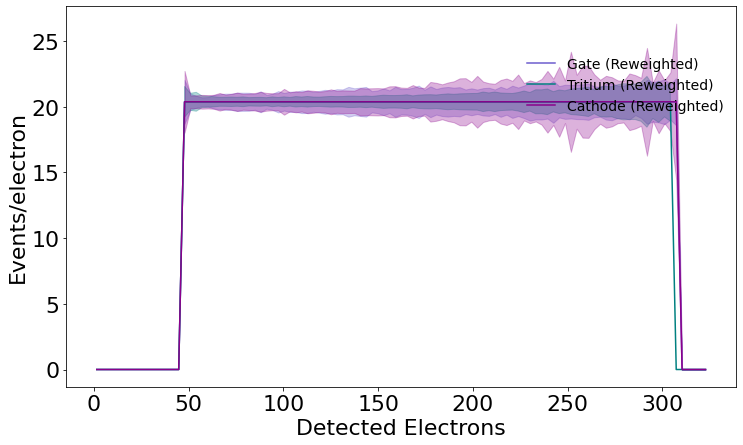

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True, sharey=True)  #Initialise new fig object to plot weighted, flat spectrum
fig.subplots_adjust(hspace=0.0)

### CODE TO DELETE: HERE FOR TESTING PURPOSES ONLY ###

areas = arr['area']
max_area = max(areas)

bins=100
electron_size = 58.5

gate_events = arr[(arr['label'] == 1)].area / electron_size

gate_hist = Hist(hist.axis.Regular(bins,0, max(areas)/electron_size ),label='S2 Gate Area Distribution')
gate_hist.fill(gate_events)

gate_counts = gate_hist.view() / bin_centers #this is the y - axis data converted to events/electron
print(gate_counts)

### 

# Calculate the target flat spectrum as the average of the three histograms
gate_data = gate_hist.view(flow=False)
tritium_data = tritium_hist.view(flow=False) 
cathode_data = cathode_hist.view(flow=False) 


print(gate_counts.sum()) # total area under the histogram (integral of histogram)
print(tritium_counts.sum()) # total area under the histogram (integral of histogram)
print(cathode_counts.sum()) # total area under the histogram (integral of histogram)

average_counts = np.mean([gate_counts.sum(), tritium_counts.sum(),cathode_counts.sum()])

#for datapoint in range(0, len(gate_data)):
    #print(gate_data[datapoint])

#gate_reweighted = np.array([
    #gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0
    #for datapoint in range(len(gate_counts))
#])

gate_weights = []
gate_reweighted  = []
for datapoint in range(len(gate_counts)):
    gate_reweighted.append(gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0)
    gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))


tritium_weights = []
tritium_reweighted = []
for datapoint in range(len(tritium_counts)):
    tritium_reweighted.append(tritium_counts[datapoint] * (1 / (tritium_counts[datapoint] / tritium_counts.sum())) if tritium_counts[datapoint] != 0 else 0)
    tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))

cathode_weights = []
cathode_reweighted = []
for datapoint in range(len(cathode_counts)):
    cathode_reweighted.append(cathode_counts[datapoint] * (1 / (cathode_counts[datapoint] / cathode_counts.sum())) if cathode_counts[datapoint] != 0 else 0)
    cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()))

gate_reweighted = np.array(gate_reweighted)
tritium_reweighted = np.array(tritium_reweighted)
cathode_reweighted = np.array(cathode_reweighted)

# print(gate_reweighted)
# print(tritium_reweighted)

#errorbars
gate_errors = np.sqrt(gate_counts) * gate_weights /60 # * (average_counts / gate_counts.sum())
tritium_errors = np.sqrt(tritium_counts) * tritium_weights /60 # * (average_counts / tritium_counts.sum())
cathode_errors = np.sqrt(cathode_counts) * cathode_weights/60 # * (average_counts / cathode_counts.sum())

# Append zeros to make the histogram look like a "tophat"
tophat_padding = 5  # Number of zeros to add
gate_reweighted = np.append(gate_reweighted, [0] * tophat_padding)
tritium_reweighted = np.append(tritium_reweighted, [0] * tophat_padding)
cathode_reweighted = np.append(cathode_reweighted, [0] * tophat_padding)

gate_errors = np.append(gate_errors, [0] * tophat_padding)
tritium_errors = np.append(tritium_errors, [0] * tophat_padding)
cathode_errors = np.append(cathode_errors, [0] * tophat_padding)

# Extend bin_centers by adding extra bins to match the "tophat" shape
bin_step = bin_centers[1] - bin_centers[0]  # Calculate the step size between bins
extended_bin_centers = np.append(bin_centers, bin_centers[-1] + bin_step * np.arange(1, tophat_padding + 1))


# Apply reweighting by multiplying the original data by the weights

# Plot reweighted data with translucent error bands
# Gate
ax.plot(extended_bin_centers, gate_reweighted * (average_counts / gate_counts.sum()), color='slateblue', label='Gate (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (gate_reweighted - gate_errors) * (average_counts / gate_counts.sum()), 
    (gate_reweighted + gate_errors) * (average_counts / gate_counts.sum()), 
    color='slateblue', alpha=0.3
)

# Tritium
ax.plot(extended_bin_centers, tritium_reweighted * (average_counts / tritium_counts.sum()), color='teal', label='Tritium (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (tritium_reweighted - tritium_errors) * (average_counts / tritium_counts.sum()), 
    (tritium_reweighted + tritium_errors) * (average_counts / tritium_counts.sum()), 
    color='teal', alpha=0.3
)

# Cathode
ax.plot(extended_bin_centers, cathode_reweighted * (average_counts / cathode_counts.sum()), color='darkmagenta', label='Cathode (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (cathode_reweighted - cathode_errors) * (average_counts / cathode_counts.sum()), 
    (cathode_reweighted + cathode_errors) * (average_counts / cathode_counts.sum()), 
    color='darkmagenta', alpha=0.3
)

#ax.step(bin_centers, gate_reweighted * (average_counts/ gate_counts.sum()), where='mid', color='slateblue', label='Gate (Reweighted)')
#ax.step(bin_centers, tritium_reweighted * (average_counts/ tritium_counts.sum()), where='mid', color='teal', label='Tritium (Bulk, Reweighted)')
#ax.step(bin_centers, cathode_reweighted * (average_counts/ cathode_counts.sum()), where='mid', color='darkmagenta', label='Cathode (Reweighted)')


ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1,0.9),loc='upper right',frameon=False,fontsize=14) 
plt.savefig('Figures/weighted_pulse_spectrum.png', dpi=1800)
plt.show()

# Creating the Weight Array to Feed into CNN

In [12]:
gate_weights = np.array(gate_weights)
gate_weights = np.where(np.isinf(gate_weights), 0, gate_weights)

tritium_weights = np.array(tritium_weights)
tritium_weights = np.where(np.isinf(tritium_weights), 0, tritium_weights)

cathode_weights = np.array(cathode_weights)
cathode_weights = np.where(np.isinf(cathode_weights), 0, cathode_weights)


#gate_weights = gate_weights.ravel() # gate_weights was found to be a 2D array with only 1 row which prohibited proper indexing. ravel() flattens to 1D ndarray.
print(f'these are da {gate_weights.size}')


#print(gate_data)
#print(gate_weights)

print(gate_data.sum())
print(tritium_data.sum())
print(cathode_data.sum())

def subdataset_total_weights(dataset_weights, n_data_per_bin):
    n_data_per_bin = np.array(n_data_per_bin, dtype=int) #creates a copy of array that is an ndarray with every element being an integer
    weight_list = []
    for i in range(bins):
        weight_list.extend([dataset_weights[i]] * n_data_per_bin[i])
    return np.array(weight_list)

g_weights = subdataset_total_weights(gate_weights, gate_data)
t_weights = subdataset_total_weights(tritium_weights, tritium_data)
c_weights = subdataset_total_weights(cathode_weights, cathode_data)

print(g_weights.size + t_weights.size + c_weights.size)
print(type(g_weights))
print(len(arr))


#arr['weight'] = all_weights #the final line to add all weights for each subdataset (gate, cathode and tritium) to main awkward data frame. then can feed into CNN easy.


these are da 100
1711.0
4882.0
1189.0
7782
<class 'numpy.ndarray'>
7782


# Creating and Populating the New Weight Column in the Main Dataframe

In [13]:
weight_column_4_mainarray = np.zeros(len(arr))
# print(len(arr['weights'])) #check to ensure its same length as number of training examples

# Now we need to create an iterative loop that finds a cathode, gate or tritium training example and populates its assoicated weight with the correct weight parameter from its respective weight array

gate_event_counter = 0
cathode_event_counter = 0
tritium_event_counter = 0

print(len(t_weights))

for i in range(len(arr)):
    if arr['label'][i] == 0: # Cathode
        # print(g_weights[i])
        weight_column_4_mainarray[i] = c_weights[gate_event_counter]
        gate_event_counter += 1
    elif arr['label'][i] == 1: # Gate
        weight_column_4_mainarray[i] = g_weights[cathode_event_counter]
        cathode_event_counter += 1
    else: # Tritium (as we have already verified there are no None or NaN entries)
        weight_column_4_mainarray[i] = t_weights[tritium_event_counter]
        tritium_event_counter += 1

arr['weights'] = weight_column_4_mainarray # a new weight column has been initialised!

4882


# Convolutional Neural Network

Convolutional layers should improve the accuracy further but will even longer to run. You should try to understand what filters, pooling, and kernal size are. These are the hyperparameters you need to mess around with, as well as the number of convolutional layers. The filters will be used to look for certain features of the S2 waveforms so I think the kernal size should be decided based on the size of features you are trying to select. Here is a descriptive link: https://www.simplilearn.com/tutorials/deep-learning-tutorial/convolutional-neural-network#:~:text=A%20convolutional%20neural%20network%20is,classify%20objects%20in%20an%20image. This made my computer start to overheat, hence the desire to use a gpu, but maybe we are okay.

In [14]:
convoNN = keras.Sequential([
    # First 1D convolution layer
    keras.layers.Conv1D(filters=28, kernel_size=3, activation='relu', input_shape=(3656, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Second 1D convolution layer
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Flatten layer to connect to dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Adjust output size for the number of classes
])

# Compile the model
convoNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#CNN with 7 layers
#the first two Conv2D extract spatial features from the image- i.e. there will be 28 filters that will scan the image for patterns, each filter extracts different features from the image (e.g.textures, edges)
#max Pooling layer performs down-sampling to resduce spatial dimensions
#(2,2) specifies a pooling window which means the layer will take the max value from every 2*2 region
#flatten layer converts information from 2D map to a 1D vector
#64 layer is a dense layer with 64 neurons
#10 layer is our 10 neuron layer that provides a class (digit 0-1)

In [15]:
convoNN.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [16]:
weights_np = ak.to_numpy(arr['weights'])
print(len(weights_np))
# An issue arises here initially as arr['weights'] is an awkward array. Keras only recognises and deals with a NumPy array therefore conversion is neccessary
# Another issue also arises in that the test and train data do not have asscoated weights as the weights column was initialised after the split was made
# 'arr' is the original dataset
normalized_area = ak.to_numpy(arr['area'] / electron_size)  # converting 'area' to detected electrons by dividing by 58.5

labels = arr['label']
# Assuming you already have 'X_combined' and 'labels' prepared
# Split the data (include 'area' normalization within the split for alignment)
X_train, X_test, y_train, y_test, area_train, area_test, weights_train, weights_test = train_test_split(
    X_combined, labels, normalized_area, weights_np, test_size=0.25, random_state=42
)
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of weights_train:", len(weights_train))
print("Shape of weights_train:", weights_train.shape)
print("Shape of X_train:", X_train.shape)




y_train = np.array(y_train) # this is neccessary as train_test_split often returns lists instead of ndarrays but Keras.model.fit requires the functionality of ndarrays
y_test = np.array(y_test) # //
print("Shape of y_train:", y_train.shape)

convoNN.fit(X_train, y_train, sample_weight=weights_train, epochs=5) 




7782
Length of X_train: 5836
Length of y_train: 5836
Length of weights_train: 5836
Shape of weights_train: (5836,)
Shape of X_train: (5836, 3656)
Shape of y_train: (5836,)
Epoch 1/5
183/183 [==============================] - 17s 86ms/step - loss: 48.2980 - accuracy: 0.8357
Epoch 2/5
183/183 [==============================] - 19s 102ms/step - loss: 41.4039 - accuracy: 0.8535
Epoch 3/5
183/183 [==============================] - 16s 87ms/step - loss: 40.3205 - accuracy: 0.8583
Epoch 4/5
183/183 [==============================] - 20s 108ms/step - loss: 35.5540 - accuracy: 0.8708
Epoch 5/5
183/183 [==============================] - 18s 96ms/step - loss: 32.8489 - accuracy: 0.8765


In [17]:
X_test_reshaped = X_test.reshape(-1, 3656, 1)
print(X_test_reshaped.shape)
convoNN.evaluate(X_test_reshaped, y_test)

(1946, 3656, 1)
61/61 [==============================] - 1s 20ms/step - loss: 0.3782 - accuracy: 0.8571


[0.37817302346229553, 0.8571428656578064]

# Visualising the Model Classification Effectiveness: The Probability Distribution

61/61 [==============================] - 1s 20ms/step
True label: 2, Predicted class: 2
True label: 1, Predicted class: 1
True label: 0, Predicted class: 2
True label: 0, Predicted class: 0
True label: 0, Predicted class: 0
True label: 2, Predicted class: 2
True label: 0, Predicted class: 0
True label: 1, Predicted class: 1
True label: 0, Predicted class: 0
True label: 1, Predicted class: 1
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 2, Predicted class: 0
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 0, Predicted class: 0
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 1, Predicted class: 1
True label: 1, Predicted class: 1
True label: 2, Predicted class: 2
True label: 0, Predicted class: 2
True label: 2, Predicted cla

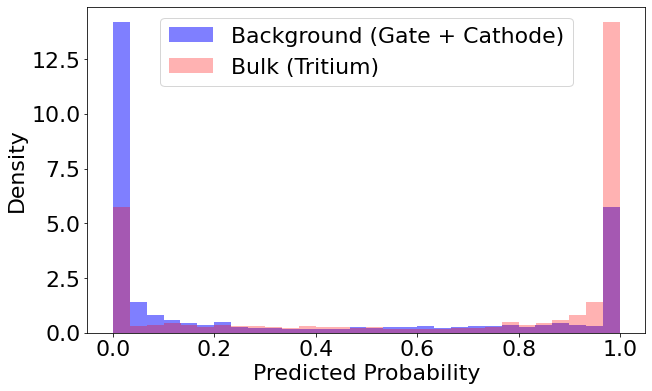

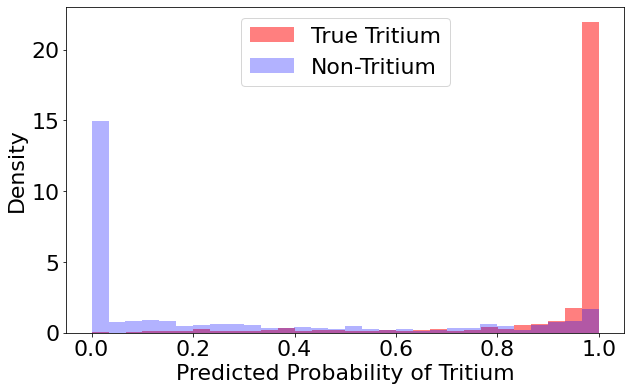

In [18]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Step 1: Get predicted probabilities for each class
y_pred_proba = convoNN.predict(X_test)

predicted_classes = np.argmax(y_pred_proba, axis=1) # axis = 1 signifies that argmax should parse through the columns of each row and find the max. value
for i in range(30):
    print(f"True label: {y_test[i]}, Predicted class: {predicted_classes[i]}")  # Initial checking to see how well the model predicts the classes for first 30 training examples 

# Step 2: Calculate background and bulk probabilities
background_proba = y_pred_proba[:, 0] + y_pred_proba[:, 1]  # Sum of Gate and Cathode probabilities
bulk_proba = y_pred_proba[:, 2]  # Tritium probabilities

# Step 3: Plot the histograms for background and bulk probabilities
plt.figure(figsize=(10, 6))

# Background probability histogram
plt.hist(background_proba, bins=30, alpha=0.5, color='blue', label='Background (Gate + Cathode)', density=True)

# Bulk (Tritium) probability histogram
plt.hist(bulk_proba, bins=30, alpha=0.3, color='red', label='Bulk (Tritium)', density=True)

# Add titles and labels
# plt.title('Probability Histogram for Background vs Bulk Classification')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()

plt.show()

# Separate true Tritium events from non-Tritium events in y_test
true_tritium_mask = (y_test == 2)
non_tritium_mask = (y_test != 2)

# Step 3: Plot histograms for both groups
plt.figure(figsize=(10, 6))

# Histogram for actual Bulk (Tritium) events
plt.hist(bulk_proba[true_tritium_mask], bins=30, alpha=0.5, color='red', label='True Tritium', density=True)

# Histogram for non-Bulk (Tritium) events
plt.hist(bulk_proba[non_tritium_mask], bins=30, alpha=0.3, color='blue', label='Non-Tritium', density=True)

# Add titles and labels
# plt.title('Predicted Probability Histogram for Tritium Classification')
plt.xlabel('Predicted Probability of Tritium')
plt.ylabel('Density')
plt.legend(loc='upper center')

plt.show()


# Creating the ROC Curves

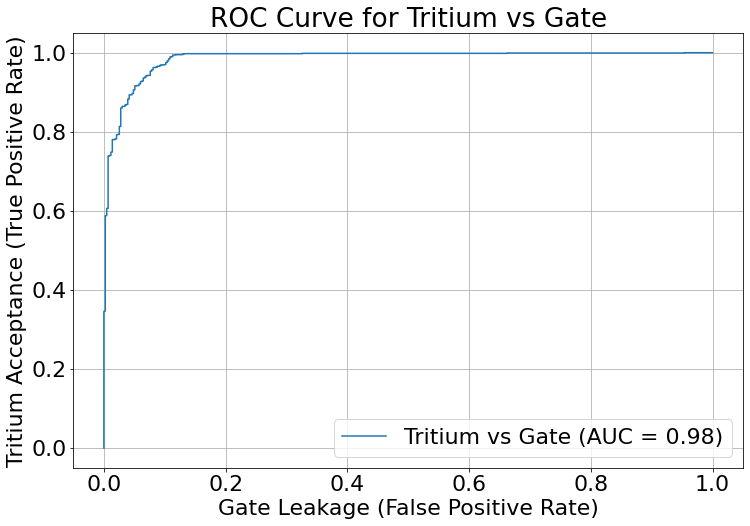

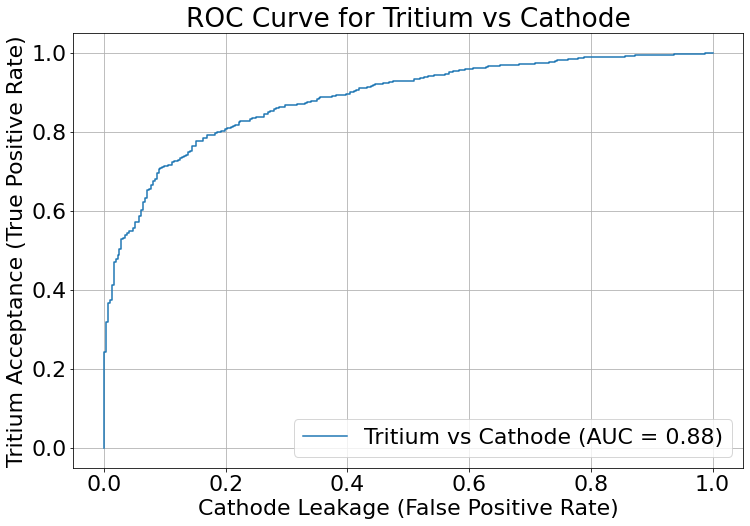

In [19]:
# Tritium vs Gate (Binary labels: Tritium as 1, Gate as 0; ignore Cathode instances)
mask_tritium_gate = (y_test == 2) | (y_test == 1)  # Only consider tritium and gate instances
y_test_tritium_gate = np.where(y_test[mask_tritium_gate] == 2, 1, 0)  # Tritium = 1, Gate = 0
fpr_gate, tpr_gate, _ = roc_curve(y_test_tritium_gate, y_pred_proba[mask_tritium_gate, 2])
roc_auc_gate = auc(fpr_gate, tpr_gate)

# Tritium vs Cathode (Binary labels: Tritium as 1, Cathode as 0; ignore Gate instances)
mask_tritium_cathode = (y_test == 2) | (y_test == 0)  # Only consider tritium and cathode instances
y_test_tritium_cathode = np.where(y_test[mask_tritium_cathode] == 2, 1, 0)  # Tritium = 1, Cathode = 0
fpr_cathode, tpr_cathode, _ = roc_curve(y_test_tritium_cathode, y_pred_proba[mask_tritium_cathode, 2])
# print(_) these are the array of thresholds used by the roc algorithm
roc_auc_cathode = auc(fpr_cathode, tpr_cathode)

# Step 3: Plot ROC curves with verification of each set
plt.figure(figsize=(12, 8))

# Plot for Tritium vs Gate
plt.plot(fpr_gate, tpr_gate, label=f'Tritium vs Gate (AUC = {roc_auc_gate:.2f})')
plt.xlabel('Gate Leakage (False Positive Rate)')
plt.ylabel('Tritium Acceptance (True Positive Rate)')
plt.title('ROC Curve for Tritium vs Gate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot for Tritium vs Cathode
plt.figure(figsize=(12, 8))
plt.plot(fpr_cathode, tpr_cathode, label=f'Tritium vs Cathode (AUC = {roc_auc_cathode:.2f})')
plt.xlabel('Cathode Leakage (False Positive Rate)')
plt.ylabel('Tritium Acceptance (True Positive Rate)')
plt.title('ROC Curve for Tritium vs Cathode')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


[ 48.75882245 100.02433894 151.28985544 202.55537193 253.82088842
 305.08640491]
[2 1 0 ... 1 2 2]
y_test_np shape: (1946,)
area_test_np shape: (1946,)


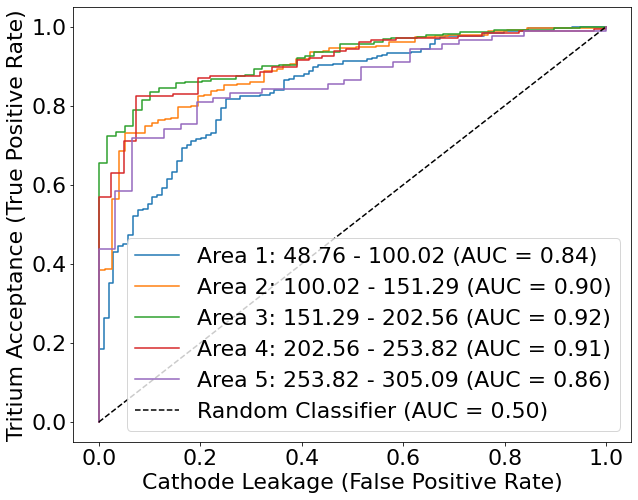

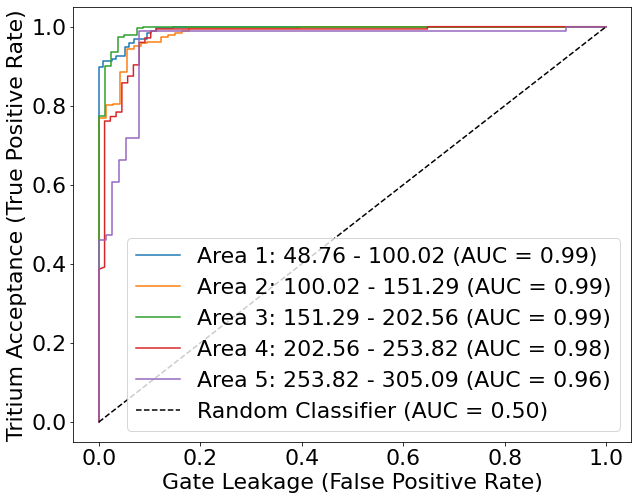

In [26]:
# Define function to split data into 5 regions based on normalized area for the test set
def get_area_intervals(normalized_area, num_intervals=5):
    min_area = np.min(normalized_area)
    max_area = np.max(normalized_area)
    intervals = np.linspace(min_area, max_area, num_intervals + 1)
    return intervals

# Calculate intervals for splitting area into 5 regions
area_intervals = get_area_intervals(area_test)
print(area_intervals)

# Convert y_test and area_test to NumPy arrays for easier indexing
y_test_np = ak.to_numpy(y_test)
print(y_test_np)
area_test_np = ak.to_numpy(area_test)

# Check conversion
print("y_test_np shape:", y_test_np.shape)
print("area_test_np shape:", area_test_np.shape)

def plot_roc_for_intervals(event_type, y_test, y_pred_proba, label, area_intervals):
    plt.figure(figsize=(10, 8))
    for i in range(len(area_intervals) - 1):
        # Define range for the current interval
        lower, upper = area_intervals[i], area_intervals[i + 1]
        
        # Mask to select data within the current area range and specific event type
        mask = (area_test_np >= lower) & (area_test_np < upper) & ((y_test_np == event_type) | (y_test_np == 2))
        # print(f' this is {y_test_np[mask]}')
        
        # Check if mask correctly applies to y_test
        if np.any(mask):  # Ensure mask is not empty. np.any() returns a boolean value iff any element within 'mask' is true
            y_test_interval = np.where(y_test_np[mask] == 2, 1, 0)  # Tritium = 1, event_type = 0
            
            # Compute ROC for this interval
            fpr, tpr, _ = roc_curve(y_test_interval, y_pred_proba[mask, 2])
            roc_auc = auc(fpr, tpr)
            
            # Plot the ROC curve for this interval
            plt.plot(fpr, tpr, label=f'Area {i+1}: {lower:.2f} - {upper:.2f} (AUC = {roc_auc:.2f})')
    
    # Plot the random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
    
    # Add labels and title
    plt.xlabel(f'{label} Leakage (False Positive Rate)')
    plt.ylabel('Tritium Acceptance (True Positive Rate)')
    # plt.title(f'ROC Curves for Tritium vs {label} across Area Regions')
    plt.legend(loc='lower right')
    plt.show()

# Step 4: Plot ROC curves for Tritium vs Cathode
plot_roc_for_intervals(event_type=0, y_test=y_test_np, y_pred_proba=y_pred_proba, label='Cathode', area_intervals=area_intervals)

# Step 5: Plot ROC curves for Tritium vs Gate
plot_roc_for_intervals(event_type=1, y_test=y_test_np, y_pred_proba=y_pred_proba, label='Gate', area_intervals=area_intervals)


Area intervals: [ 48.75882245  61.57520157  74.3915807   87.20795982 100.02433894
 112.84071807 125.65709719 138.47347631 151.28985544 164.10623456
 176.92261368 189.73899281 202.55537193 215.37175105 228.18813017
 241.0045093  253.82088842 266.63726754 279.45364667 292.27002579
 305.08640491]


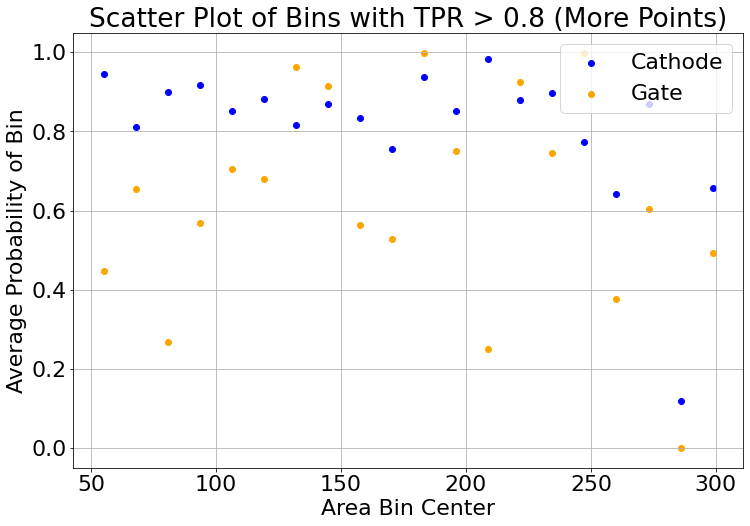

In [21]:
# Increase the number of bins for more points in the scatter plot
num_bins = 20 # Adjust this number to make the bins smaller and create more points

# Function to split data into smaller regions based on normalized area
def get_area_intervals(normalized_area, num_intervals=num_bins):
    min_area = np.min(normalized_area)
    max_area = np.max(normalized_area)
    intervals = np.linspace(min_area, max_area, num_intervals + 1)
    return intervals

# Calculate intervals for splitting area into smaller bins
area_intervals = get_area_intervals(area_test_np)
print("Area intervals:", area_intervals)

# Function to collect data points for bins with TPR > 0.8
def collect_points_above_tpr(event_type, y_test, y_pred_proba, area_intervals):
    points_above_tpr_0_8 = []  # List to store points (bin center, average probability)

    for i in range(len(area_intervals) - 1):
        # Define range for the current interval
        lower, upper = area_intervals[i], area_intervals[i + 1]
        bin_center = (lower + upper) / 2  # Calculate bin center for x-axis
        
        # Mask to select data within the current area range and specific event type
        mask = (area_test_np >= lower) & (area_test_np < upper) & ((y_test_np == event_type) | (y_test_np == 2))
        
        # Ensure mask is not empty
        if np.any(mask):
            y_test_interval = np.where(y_test_np[mask] == 2, 1, 0)  # Filtering through tritium data. Tritium = 1, event_type = 0
            
            # Compute ROC for this interval
            fpr, tpr, thresholds = roc_curve(y_test_interval, y_pred_proba[mask, 2])
            
            # Collect average probabilities for points where TPR > 0.8
            high_tpr_indices = np.where(tpr > 0.8)[0]
            if len(high_tpr_indices) > 0:
                avg_prob = np.mean(y_pred_proba[mask, 2][high_tpr_indices])
                points_above_tpr_0_8.append((bin_center, avg_prob))

    return points_above_tpr_0_8

# Collect points for tritium vs cathode with more bins
points_cathode = collect_points_above_tpr(event_type=0, y_test=y_test_np, y_pred_proba=y_pred_proba, area_intervals=area_intervals)

# Collect points for tritium vs gate with more bins
points_gate = collect_points_above_tpr(event_type=1, y_test=y_test_np, y_pred_proba=y_pred_proba, area_intervals=area_intervals)

# Plot the scatter plot for each event type
plt.figure(figsize=(12, 8))
if points_cathode:
    plt.scatter(*zip(*points_cathode), color='blue', label='Cathode')
if points_gate:
    plt.scatter(*zip(*points_gate), color='orange', label='Gate')

plt.xlabel("Area Bin Center")
plt.ylabel("Average Probability of Bin")
plt.title("Scatter Plot of Bins with TPR > 0.8 (More Points)")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()



C:\Users\44738\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\44738\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\44738\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\44738\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\44738\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No n

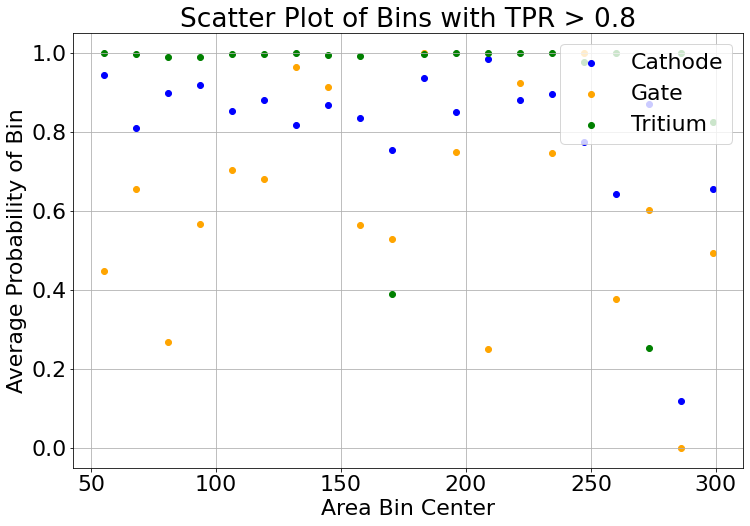

In [22]:
# Collect data points for bins with TPR > 0.8 for tritium
def collect_points_above_tpr(event_type, y_test, y_pred_proba, area_intervals):
    points_above_tpr_0_8 = []  # List to store points (bin center, average probability)

    for i in range(len(area_intervals) - 1):
        # Define range for the current interval
        lower, upper = area_intervals[i], area_intervals[i + 1]
        bin_center = (lower + upper) / 2  # Calculate bin center for x-axis
        
        # Mask to select data within the current area range and specific event type
        mask = (area_test_np >= lower) & (area_test_np < upper) & ((y_test_np == event_type) | (y_test_np == 2))
        
        # Ensure mask is not empty
        if np.any(mask):
            y_test_interval = np.where(y_test_np[mask] == 2, 1, 0)  # Tritium = 1, event_type = 0
            
            # Compute ROC for this interval
            fpr, tpr, thresholds = roc_curve(y_test_interval, y_pred_proba[mask, 2])
            
            # Collect average probabilities for points where TPR > 0.8
            high_tpr_indices = np.where(tpr > 0.8)[0]
            if len(high_tpr_indices) > 0:
                avg_prob = np.mean(y_pred_proba[mask, 2][high_tpr_indices])
                points_above_tpr_0_8.append((bin_center, avg_prob))

    return points_above_tpr_0_8

# Collect points for tritium vs cathode
points_cathode = collect_points_above_tpr(event_type=0, y_test=y_test_np, y_pred_proba=y_pred_proba, area_intervals=area_intervals)

# Collect points for tritium vs gate
points_gate = collect_points_above_tpr(event_type=1, y_test=y_test_np, y_pred_proba=y_pred_proba, area_intervals=area_intervals)

# Collect points for tritium itself (where tritium is the true event)
points_tritium = collect_points_above_tpr(event_type=2, y_test=y_test_np, y_pred_proba=y_pred_proba, area_intervals=area_intervals)

# Plot the scatter plot for each event type
plt.figure(figsize=(12, 8))
if points_cathode:
    plt.scatter(*zip(*points_cathode), color='blue', label='Cathode')
if points_gate:
    plt.scatter(*zip(*points_gate), color='orange', label='Gate')
if points_tritium:
    plt.scatter(*zip(*points_tritium), color='green', label='Tritium')

plt.xlabel("Area Bin Center")
plt.ylabel("Average Probability of Bin")
plt.title("Scatter Plot of Bins with TPR > 0.8")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


C:\Users\44738\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\44738\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\44738\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\44738\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\44738\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No n

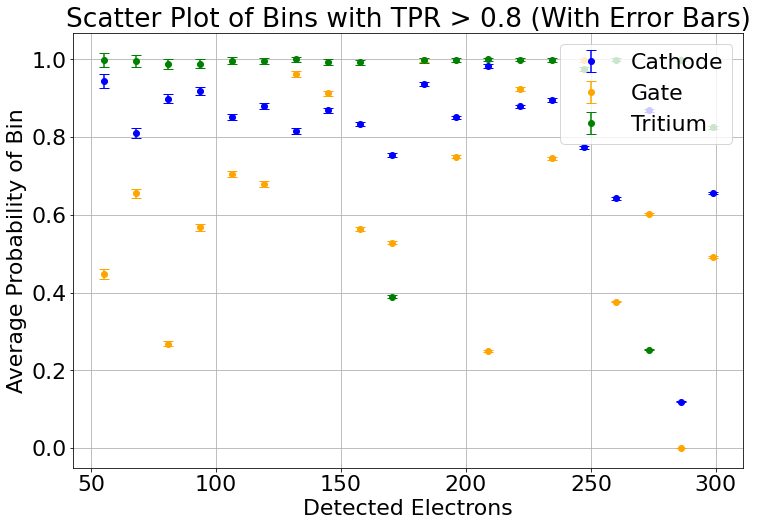

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Collect data points for bins with TPR > 0.8 for tritium
def collect_points_above_tpr(event_type, y_test, y_pred_proba, area_intervals):
    points_above_tpr_0_8 = []  # List to store points (bin center, average probability)

    for i in range(len(area_intervals) - 1):
        # Define range for the current interval
        lower, upper = area_intervals[i], area_intervals[i + 1]
        bin_center = (lower + upper) / 2  # Calculate bin center for x-axis
        
        # Mask to select data within the current area range and specific event type
        mask = (area_test_np >= lower) & (area_test_np < upper) & ((y_test_np == event_type) | (y_test_np == 2))
        
        # Ensure mask is not empty
        if np.any(mask):
            y_test_interval = np.where(y_test_np[mask] == 2, 1, 0)  # Tritium = 1, event_type = 0
            
            # Compute ROC for this interval
            fpr, tpr, thresholds = roc_curve(y_test_interval, y_pred_proba[mask, 2])
            
            # Collect average probabilities for points where TPR > 0.8
            high_tpr_indices = np.where(tpr > 0.8)[0]
            if len(high_tpr_indices) > 0:
                avg_prob = np.mean(y_pred_proba[mask, 2][high_tpr_indices])
                points_above_tpr_0_8.append((bin_center, avg_prob))

    return points_above_tpr_0_8

# Collect points for each event type
points_cathode = collect_points_above_tpr(event_type=0, y_test=y_test_np, y_pred_proba=y_pred_proba, area_intervals=area_intervals)
points_gate = collect_points_above_tpr(event_type=1, y_test=y_test_np, y_pred_proba=y_pred_proba, area_intervals=area_intervals)
points_tritium = collect_points_above_tpr(event_type=2, y_test=y_test_np, y_pred_proba=y_pred_proba, area_intervals=area_intervals)

# Function to plot points with error bars
def plot_with_error_bars(points, color, label):
    if points:
        x_vals, y_vals = zip(*points)
        # Calculate error bars as sqrt(y) / x
        errors = [np.sqrt(y) / x if x != 0 else 0 for x, y in zip(x_vals, y_vals)]
        plt.errorbar(x_vals, y_vals, yerr=errors, fmt='o', color=color, label=label, capsize=5)

# Plot the scatter plot for each event type with error bars
plt.figure(figsize=(12, 8))
plot_with_error_bars(points_cathode, color='blue', label='Cathode')
plot_with_error_bars(points_gate, color='orange', label='Gate')
plot_with_error_bars(points_tritium, color='green', label='Tritium')

plt.xlabel("Detected Electrons")
plt.ylabel("Average Probability of Bin")
plt.title("Scatter Plot of Bins with TPR > 0.8 (With Error Bars)")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
